In [2]:
import json
import torch
import os

from tqdm import tqdm
from IPython.display import clear_output

In [3]:
geom_cut = torch.load('/home/user12/maslov/mydatasets/geom_cut.pt')

In [1]:
geom = torch.load('/home/user12/maslov/mydatasets/geom_train.pt')

NameError: name 'torch' is not defined

In [13]:
with open("bond_predictions.jsonl") as f:
    for line in f:
        obj = json.loads(line)
        print(obj['labels'])
        print(obj['prompt'])
        print(obj['predictions'])
        break

[[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 0], [1, 2, 1], [1, 11, 1], [2, 1, 1], [2, 2, 0], [2, 3, 2], [2, 4, 1], [3, 2, 2], [3, 3, 0], [4, 2, 1], [4, 4, 0], [4, 5, 1], [5, 4, 1], [5, 5, 0], [5, 6, 4], [5, 10, 4], [6, 5, 4], [6, 6, 0], [6, 7, 4], [7, 6, 4], [7, 7, 0], [7, 8, 4], [8, 7, 4], [8, 8, 0], [8, 9, 4], [9, 8, 4], [9, 9, 0], [9, 10, 4], [10, 5, 4], [10, 9, 4], [10, 10, 0], [11, 1, 1], [11, 11, 0], [11, 12, 1], [12, 11, 1], [12, 12, 0], [12, 13, 4], [12, 17, 4], [13, 12, 4], [13, 13, 0], [13, 14, 4], [14, 13, 4], [14, 14, 0], [14, 15, 4], [15, 14, 4], [15, 15, 0], [15, 16, 4], [15, 18, 1], [16, 15, 4], [16, 16, 0], [16, 17, 4], [17, 12, 4], [17, 16, 4], [17, 17, 0], [18, 15, 1], [18, 18, 0]]
You are a chemist. For each atom pair within 2 Å classify the bond type:
0 0
0 1
1 0
1 1
1 2
1 11
2 1
2 2
2 3
2 4
3 2
3 3
4 2
4 4
4 5
5 4
5 5
5 6
5 10
6 5
6 6
6 7
7 6
7 7
7 8
8 7
8 8
8 9
9 8
9 9
9 10
10 5
10 9
10 10
11 1
11 11
11 12
12 11
12 12
12 13
12 17
13 12
13 13
13 14
14 13
14 14
14 15
1

In [8]:
from rdkit import Chem
from rdkit.Chem import rdchem
from rdkit.Chem import AllChem

ALLOWED_ATOM_TYPES = ["C", "O", "N", "F", "S", "Cl", "Br", "I", "P"]

bond_type_map = {
    1: rdchem.BondType.SINGLE,
    2: rdchem.BondType.DOUBLE,
    3: rdchem.BondType.TRIPLE,
    4: rdchem.BondType.AROMATIC,   # модель помечает ароматические связи отдельным классом
}

def one_hot_to_symbols(one_hot_tensor):
    """torch.Tensor [N,9] → List[str]"""
    idx = one_hot_tensor.argmax(dim=-1).tolist()          # [N]
    return [ALLOWED_ATOM_TYPES[i] for i in idx]

def geom_entry_to_mol(entry, bond_list):
    """
    entry: один словарь из geom_cut.pt
           должен иметь 'one_hot'  [N,9]  и 'positions' [N,3]
    bond_list: List[[i,j,label]]  (обычно из bond_predictions.jsonl)
    """
    # 1. атомы
    symbols = one_hot_to_symbols(entry["one_hot"].cpu())   # Detach от GPU
    mol = Chem.RWMol()
    for s in symbols:
        mol.AddAtom(Chem.Atom(s))

    # 2. координаты → Conformer
    pos = entry["positions"].cpu().tolist()               # [[x,y,z], ...]
    conf = Chem.Conformer(len(symbols))
    for i, (x, y, z) in enumerate(pos):
        conf.SetAtomPosition(i, (float(x), float(y), float(z)))
    mol.AddConformer(conf)

    # 3. связи из предсказаний
    for i, j, lbl in bond_list:
        if lbl == 0:
            continue  # «no-bond»
        if max(i, j) >= len(symbols):
            # пара вылезла за пределы; аккуратно пропустим
            continue
        bt = bond_type_map.get(lbl)
        if bt is None:
            continue
        try:
            if mol.GetBondBetweenAtoms(i, j) is None:
                mol.AddBond(i, j, bt)
        except Exception as e:
            # RDKit может ругнуться, если связь дублируется или нарушает валентность
            # print(f"⚠️  Bond ({i},{j}) skipped: {e}")
            continue

    # 4. финал: sanitise + SMILES
    try:
        mol = mol.GetMol()
        Chem.SanitizeMol(mol)           # проверка валентностей, уд. гидрогенов и т.д.
        # Пробуем кекулизовать для стабильного SMILES
        Chem.Kekulize(mol, clearAromaticFlags=True)
    except Exception as e:
        # print("❌ Sanitize failed:", e)
        return None, None

    smiles = Chem.MolToSmiles(mol)
    return mol, smiles


In [52]:
geom_cut[0]

{'name': 'CC(Oc1ccc(Cl)cc1)C(=O)Nc1ncccn1',
 'one_hot': tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0'),
 'positions': tensor([[-1.7910, -

In [37]:
Chem.MolToSmiles(Chem.MolFromSmiles(geom_cut[0]['name']))

'CC(Oc1ccc(Cl)cc1)C(=O)Nc1ncccn1'

In [4]:
with open("bond_predictions.jsonl") as f:
    preds = [json.loads(l) for l in f]


In [9]:
N = len(preds)

In [11]:
acc = sum([pred['predictions'] == pred['labels'] for pred in preds]) / N

print(f'Exact match: {acc:.4f}')

Exact match: 0.9783


In [19]:
geom_cut[0]

{'name': 'CC(Oc1ccc(Cl)cc1)C(=O)Nc1ncccn1',
 'one_hot': tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0'),
 'positions': tensor([[-1.7910, -

In [14]:

results = []
for entry, pred in tqdm(zip(geom_cut, preds[:10000]), total=len(geom_cut)):
    mol, smi = geom_entry_to_mol(entry, pred["predictions"])
    results.append({"name": entry["name"], "smiles_pred": smi})
    # clear_output()
# with open("predicted_smiles.jsonl", "w") as out:
#     for r in results:
#         out.write(json.dumps(r) + "\n")


  0%|          | 0/10000 [00:00<?, ?it/s][11:06:33] Can't kekulize mol.  Unkekulized atoms: 6 7 9 10 11 12 14
[11:06:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[11:06:33] Explicit valence for atom # 6 N, 4, is greater than permitted
[11:06:33] Explicit valence for atom # 28 N, 4, is greater than permitted
[11:06:33] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[11:06:33] Explicit valence for atom # 1 N, 4, is greater than permitted
[11:06:33] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:06:33] Explicit valence for atom # 12 N, 4, is greater than permitted
[11:06:33] Explicit valence for atom # 18 N, 4, is greater than permitted
[11:06:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[11:06:33] Explicit valence for atom # 3 C, 5, is greater than permitted
[11:06:33] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 19
[11:06:33] Can't kekulize mol.  Unkekulized atoms: 1 2 26
[11:06:33] Can't kekulize mol.  Unkekulized atom

In [22]:
Chem.MolFromSmiles(geom_cut[3202]['name'])

[11:08:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 7 8


In [43]:
all_num = len(results)
failed_num = 0
true_pred_num = 0
false_pred_num = 0
fails = []
falses = []
for i, res in enumerate(results[:9990]):
    m1 = Chem.MolFromSmiles(res['name'])
    if res['smiles_pred'] == None or m1 == None: 
        if m1 == None: print(i)
        failed_num += 1 
        fails.append({f"{i}": res})
        continue
    m2 = Chem.MolFromSmiles(res['smiles_pred'])
    if m1 == None: print(i)
    are_same = m2.HasSubstructMatch(m1) and m1.HasSubstructMatch(m2)
    if are_same: true_pred_num += 1
    else: 
        false_pred_num += 1 
        falses.append({f"{i}": res})
    
print(f'Failed to process: {failed_num / all_num:.1%}')
print(f'Succeded to process: {true_pred_num / all_num:.1%}')
print(f'Processed wrongly: {false_pred_num / all_num:.1%}')

[11:19:41] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8


1033


[11:19:42] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6


1811


[11:19:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 7 8
[11:19:42] Explicit valence for atom # 4 N, 4, is greater than permitted


3202
3591


[11:19:42] Explicit valence for atom # 3 N, 4, is greater than permitted
[11:19:43] Explicit valence for atom # 1 N, 4, is greater than permitted


4050
4402


[11:19:43] Explicit valence for atom # 2 N, 4, is greater than permitted


4658


[11:19:43] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:19:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


5271
5507


[11:19:43] Explicit valence for atom # 6 N, 4, is greater than permitted
[11:19:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7


5860
5885


[11:19:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 8
[11:19:44] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8


6590
6822


[11:19:44] Explicit valence for atom # 3 N, 4, is greater than permitted


9200
9858
Failed to process: 14.6%
Succeded to process: 77.6%
Processed wrongly: 7.7%


[11:19:45] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7


In [45]:
geom_cut[1033]['name']

'Cc1n[nH]c([NH])c(C)n1'

In [46]:
Chem.MolFromSmiles(geom_cut[1033]['name'])

[11:20:12] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8


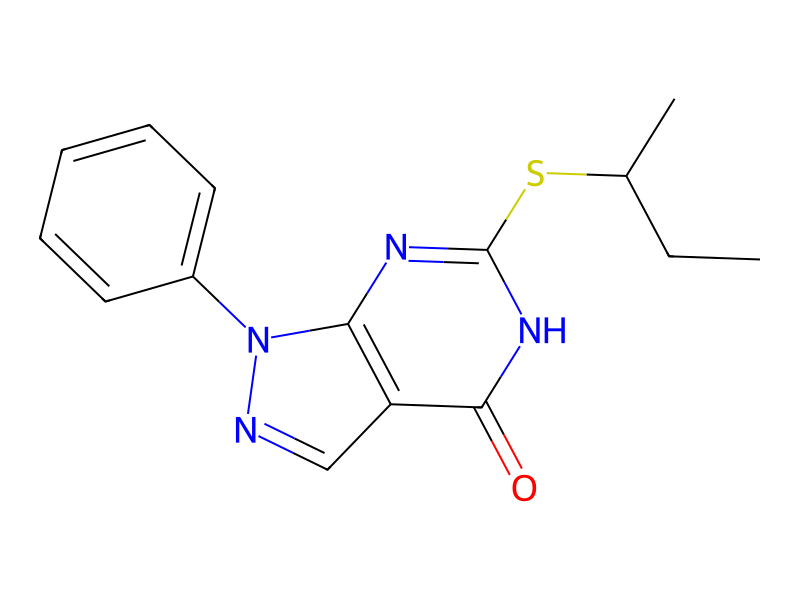

In [32]:
Chem.Draw.MolToImage(Chem.MolFromSmiles(geom_cut[7]['name']), size=(800, 600))

In [42]:
geom_cut[7]['name']

'CCC(C)Sc1nc2c(cnn2-c2ccccc2)c(=O)[nH]1'

In [35]:
fails[:3]

[{'7': {'name': 'CCC(C)Sc1nc2c(cnn2-c2ccccc2)c(=O)[nH]1',
   'smiles_pred': None}},
 {'11': {'name': 'c1c[nH]c(C[C@H]2CN2)n1', 'smiles_pred': None}},
 {'20': {'name': 'Nc1nc([N+](=O)[O-])co1', 'smiles_pred': None}}]

In [36]:
falses[:3]

[{'6': {'name': 'CCN1CC[NH+](CC(O)COc2ccc3c(c2)CCC3)CC1',
   'smiles_pred': 'CCN1CCN(CC(O)COC2=CC3=C(C=C2)CCC3)CC1'}},
 {'17': {'name': 'CCC(C)[NH2+]Cc1ccc(C(=O)OC)o1',
   'smiles_pred': 'CCC(C)NCC1=CC=C(C(=O)OC)O1'}},
 {'21': {'name': 'C[C@]12N[C@H]1[C@H]1O[C@@H]2[C@H]1O',
   'smiles_pred': 'CC12NC1C13OC21C3O'}}]

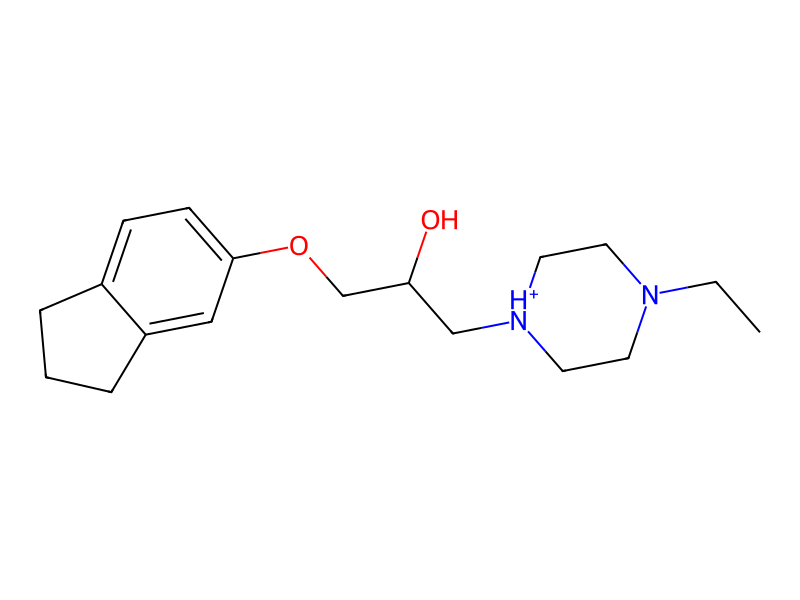

In [40]:
Chem.Draw.MolToImage(Chem.MolFromSmiles(falses[0]['6']['name']), size=(800, 600))

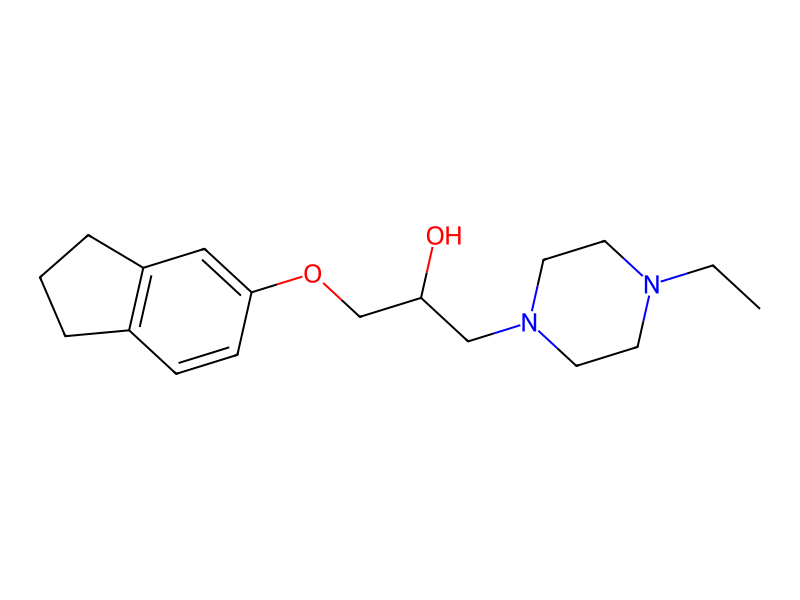

In [41]:
Chem.Draw.MolToImage(Chem.MolFromSmiles(falses[0]['6']['smiles_pred']), size=(800, 600))

In [ ]:
# geom_bond_eval.py
import torch, json, numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import rdchem, SDWriter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

ALLOWED_ATOM_TYPES = ["C", "O", "N", "F", "S", "Cl", "Br", "I", "P"]
bond_type_map = {
    1: rdchem.BondType.SINGLE,
    2: rdchem.BondType.DOUBLE,
    3: rdchem.BondType.TRIPLE,
    4: rdchem.BondType.AROMATIC,
}

# ---------- helpers ----------------------------------------------------------
def one_hot_to_symbols(one_hot):
    return [ALLOWED_ATOM_TYPES[v.argmax()] for v in one_hot]

def dedup_bonds(bond_list):
    edge2lbl = {}
    for i, j, lbl in bond_list:
        if lbl == 0:                # пропускаем «no-bond»
            continue
        key = tuple(sorted((int(i), int(j))))
        edge2lbl[key] = max(edge2lbl.get(key, 0), lbl)
    return [(i, j, lbl) for (i, j), lbl in edge2lbl.items()]

def build_mol(symbols, positions, bonds):
    mol = Chem.RWMol()
    [mol.AddAtom(Chem.Atom(s)) for s in symbols]

    conf = Chem.Conformer(len(symbols))
    for idx, (x, y, z) in enumerate(positions):
        conf.SetAtomPosition(idx, (float(x), float(y), float(z)))
    mol.AddConformer(conf)

    for i, j, lbl in dedup_bonds(bonds):
        if mol.GetBondBetweenAtoms(i, j):   # уже есть
            continue
        mol.AddBond(i, j, bond_type_map[lbl])
    try:
        m = mol.GetMol()
        Chem.SanitizeMol(m)
        Chem.Kekulize(m, clearAromaticFlags=True)
        return m
    except Exception:
        return None

def bond_dict(mol):
    """{(i,j): order_int} без ориентации"""
    dt = {rdchem.BondType.SINGLE:1, rdchem.BondType.DOUBLE:2,
          rdchem.BondType.TRIPLE:3, rdchem.BondType.AROMATIC:4}
    return {tuple(sorted((b.GetBeginAtomIdx(), b.GetEndAtomIdx()))): dt[b.GetBondType()]
            for b in mol.GetBonds()}

# ---------- main pipeline ----------------------------------------------------
# geom      = torch.load("geom_cut.pt", map_location="cpu")
geom = geom_cut
# pred_json = [json.loads(l) for l in open("bond_predictions.jsonl")]

w_true = SDWriter("geom_true.sdf")
w_pred = SDWriter("geom_pred.sdf")

acc, prec, rec, f1 = [], [], [], []
fail = 0
for entry, pred in tqdm(zip(geom, pred_json), total=len(geom)):
    symbols   = one_hot_to_symbols(entry["one_hot"])
    positions = entry["positions"].tolist()

    # --- ground-truth bonds из bond_orders ---
    true_bonds = []
    bo = entry["bond_orders"].argmax(dim=-1)     # [N,N] → order
    N  = bo.shape[0]
    for i in range(N):
        for j in range(i+1, N):
            lbl = int(bo[i, j])
            if lbl > 0:
                true_bonds.append([i, j, lbl])

    # --- RDKit моли ---
    m_true = build_mol(symbols, positions, true_bonds)
    m_pred = build_mol(symbols, positions, pred["predictions"])
    if m_true is None or m_pred is None:
        fail += 1
        continue

    w_true.write(m_true)
    w_pred.write(m_pred)

    # --- метрики ---
    d_true = bond_dict(m_true)
    d_pred = bond_dict(m_pred)
    # дополняем отсутствующие ключи значением -1
    keys = set(d_true) | set(d_pred)
    y_true = np.array([d_true.get(k, -1) for k in keys])
    y_pred = np.array([d_pred.get(k, -1) for k in keys])

    acc .append( accuracy_score(y_true, y_pred) )
    prec.append( precision_score(y_true, y_pred, average="weighted", zero_division=0) )
    rec .append( recall_score(y_true, y_pred, average="weighted", zero_division=0) )
    f1  .append( f1_score(y_true, y_pred, average="weighted", zero_division=0) )

w_true.close(); w_pred.close()

print(f"Samples OK / failed: {len(acc)} / {fail}")
print(f"Accuracy : {np.mean(acc):.4f} ± {np.std(acc):.4f}")
print(f"Precision: {np.mean(prec):.4f} ± {np.std(prec):.4f}")
print(f"Recall   : {np.mean(rec):.4f} ± {np.std(rec):.4f}")
print(f"F1-score : {np.mean(f1):.4f} ± {np.std(f1):.4f}")


In [ ]:
yuel_preds = torch.load('/home/user12/burov/yuel_bond/test_results/geom_test_predictions.pt')
geom_test = torch.load('/home/user12/burov/yuel_bond/datasets/geom_train_test.pt')

In [113]:
len(yuel_preds), len(geom_test)

(43648, 43648)

In [173]:
edge_pred = yuel_preds[0]['edge_pred']
bond_types = torch.argmax(edge_pred.squeeze(0), dim=1)
bond_probs = torch.softmax(edge_pred.squeeze(0), dim=1)
bond_types

tensor([0, 9, 9, 0, 0, 9, 9, 0, 9, 9, 0, 1, 0, 9, 9, 1, 9, 9, 0, 9, 0, 9, 9, 0,
        9, 0, 0, 9, 9, 9, 9, 0, 0, 0, 9, 0, 0, 9, 0, 0])

In [180]:
geom_test[0]['bond_orders'].argmax(dim=-1), yuel_preds[0]['edge_pred'].to('cuda').squeeze(0).argmax(-1)

(tensor([0, 9, 9, 0, 0, 9, 9, 0, 9, 9, 0, 1, 0, 9, 9, 1, 9, 9, 0, 9, 0, 9, 9, 0,
         9, 0, 0, 9, 9, 9, 9, 0, 0, 0, 9, 0, 0, 9, 0, 0], device='cuda:0'),
 tensor([0, 9, 9, 0, 0, 9, 9, 0, 9, 9, 0, 1, 0, 9, 9, 1, 9, 9, 0, 9, 0, 9, 9, 0,
         9, 0, 0, 9, 9, 9, 9, 0, 0, 0, 9, 0, 0, 9, 0, 0], device='cuda:0'))

In [177]:
sum([int(torch.all((geom_mol['bond_orders'].argmax(dim=-1) ==\
    yuel_mol['edge_pred'].to('cuda').squeeze(0).argmax(-1)).sum())) for geom_mol, yuel_mol in zip(geom_test, yuel_preds)]) / N

1.0

In [144]:
torch.all(geom_test[0]['edge_index'] == yuel_preds[0]['edge_index'].to('cuda'))

tensor(True, device='cuda:0')

In [75]:
(geom_test[0]['edge_index'] * geom_test[0]['edge_mask'].reshape(-1, 1)).shape

torch.Size([40, 2])

In [107]:
yuel_preds[1]['edge_pred'].shape, yuel_preds[1]['edge_mask'].shape


(torch.Size([16, 204, 10]), torch.Size([16, 204, 1]))

In [84]:
geom_test[0]['positions'].shape, yuel_preds[0]['positions'].shape

(torch.Size([9, 3]), torch.Size([16, 35, 3]))

In [86]:
(yuel_preds[0]['edge_index'] * yuel_preds[0]['edge_mask'])[0].shape

torch.Size([226, 2])

In [90]:
# geom_test: list[dict] (43 648 шт.)
name2true = {}
for g in geom_test:
    name2true[g["name"]] = {
        "bond_orders": g["bond_orders"].cpu(),   # [N,N,5] или [N,N]
        "edge_index":  g["edge_index"].cpu(),    # [E,2]   (если есть)
        "edge_mask":   g["edge_mask"].cpu(),     # [E]
    }


In [91]:
def bond_order_matrix(bond_orders):
    """Приходят либо [N,N,5] (one-hot), либо [N,N] (integers 0-4)."""
    return bond_orders.argmax(-1) if bond_orders.dim() == 3 else bond_orders

def labels_from_edges(bond_mat, edge_idx):
    """bond_mat [N,N], edge_idx [E,2] → list[int]"""
    return [int(bond_mat[i, j]) for i, j in edge_idx.tolist()]


In [93]:
def labels_for_valid_edges(bond_mat, edge_idx, node_mask):
    """
    Возвращает два списка одинаковой длины:
      y_true — порядки связей из bond_mat
      sel_idx — boolean-маска (len==E) какие рёбра оставили
    Оставляем только те, где оба узла не замаскированы.
    """
    sel = []
    y   = []
    nm  = node_mask.bool()          # [N]
    for k, (i, j) in enumerate(edge_idx.tolist()):
        if nm[i] and nm[j]:         # оба узла «живые»
            sel.append(True)
            y.append(int(bond_mat[i, j]))
        else:
            sel.append(False)
    return torch.tensor(y), torch.tensor(sel)      # y_true, mask[E]


In [ ]:
import torch, numpy as np, json
from tqdm import tqdm

# ─────────────────── helpers ────────────────────────────────────────────────
def compact_live_mask(node_mask):
    """node_mask [N_pad,1]→bool[N_pad];  old_idx→new_idx"""
    live = node_mask.squeeze(-1).bool()
    old2new = {old: new for new, old in enumerate(live.nonzero(as_tuple=True)[0].tolist())}
    return live, old2new

def true_labels_from_bond_orders(bond_orders, edge_idx_cmp):
    """
    bond_orders: Tensor
        • [E]      → прямые порядки
        • [E,5]    → one-hot → argmax
        • [N,N] or [N,N,5] → квадрат
    edge_idx_cmp: Tensor [E_valid,2] (компактные индексы!)
    """
    if bond_orders.dim() == 1:                             # [E]
        return bond_orders

    if bond_orders.dim() == 2 and bond_orders.size(1) == 5:  # [E,5]
        return bond_orders.argmax(-1)

    # квадратная матрица
    if bond_orders.dim() == 3:                              # [N,N,5]
        bond_mat = bond_orders.argmax(-1)
    else:                                                   # [N,N]
        bond_mat = bond_orders
    return torch.tensor([int(bond_mat[i, j]) for i, j in edge_idx_cmp.tolist()])

# ─────────────────── ground-truth dict ─────────────────────────────────────
geom_test = torch.load("geom_test.pt", map_location="cpu")

name2true = {
    d["name"]: {
        "bond_orders": d["bond_orders"].cpu(),
        "node_mask"  : d["node_mask"].cpu(),
        "edge_index" : d["edge_index"].cpu(),        # пригодится, если bond_orders — [E]
        "edge_mask"  : d["edge_mask"].cpu()
    }
    for d in geom_test
}

# ─────────────────── подсчёт Exact-Match ───────────────────────────────────
yuel_preds = torch.load("yuel_preds.pt", map_location="cpu")   # 2 728 батчей

tot, ok = 0, 0

for batch in tqdm(yuel_preds):
    edge_pred  = batch["edge_pred" ].cpu()          # [B,E,5]
    edge_index = batch["edge_index"].long().cpu()   # [B,E,2]
    edge_mask  = batch["edge_mask"].squeeze(-1).cpu() # [B,E]
    names      = batch["name"]

    for b, name in enumerate(names):
        gt = name2true[name]

        node_mask = gt["node_mask"].squeeze(-1).bool()   # [N_pad]
        live_nodes, old2new = compact_live_mask(gt["node_mask"])

        # ① маска «реальные рёбра»
        mask_live_edges = (
            edge_mask[b].bool() &
            live_nodes[edge_index[b,:,0]] &
            live_nodes[edge_index[b,:,1]]
        )
        if not mask_live_edges.any():
            continue

        sel_idx   = mask_live_edges.nonzero(as_tuple=True)[0]   # позиции в массиве рёбер
        ei_live   = edge_index[b][sel_idx]                      # [E_valid,2] (pad-индексы)
        # → в компактные индексы 0..N_valid-1
        ei_cmp = torch.tensor([[old2new[i], old2new[j]] for i,j in ei_live.tolist()])

        # предсказания
        y_pred = edge_pred[b].argmax(-1)[sel_idx]               # [E_valid]

        # истинные порядки
        bond_orders = gt["bond_orders"]
        if bond_orders.dim() <= 2:                              # [E] или [E,5]
            # тот же порядок рёбер, что и в gt['edge_index']:
            # подберём те же sel_idx
            y_true_full = (bond_orders.argmax(-1) if bond_orders.dim()==2 else bond_orders)
            y_true = y_true_full[sel_idx]
        else:                                                   # квадрат
            y_true = true_labels_from_bond_orders(bond_orders, ei_cmp)

        # Exact-Match
        tot += 1
        if torch.equal(y_pred, y_true):
            ok += 1

print(f"Exact-Match Accuracy: {ok}/{tot}  =  {ok/tot:.4%}")


In [95]:
tot = ok = 0

for batch in yuel_preds:                       # 2728 батч-обёрток
    edge_pred = batch["edge_pred"].cpu()       # [B,E,5]
    edge_index= batch["edge_index"].cpu()      # [B,E,2]
    edge_mask = batch["edge_mask"].cpu().squeeze()  # [B,E]
    names     = batch["name"]                  # длина B

    for b, name in enumerate(names):
        true = name2true[name]                 # достали ground-truth
        node_mask_true = true["edge_mask"].squeeze(0).cpu()   # [N]
        bond_mat = bond_order_matrix(true["bond_orders"])

        # --- какие рёбра сравниваем -----------------------------
        # 1) не-паддинговые по edge_mask
        # 2) концы ребра лежат на живых узлах по node_mask_true
        y_true, live_edges = labels_for_valid_edges(
            bond_mat,
            edge_index[b],
            node_mask_true,
        )
        # теперь учтём edge_mask:
        live_edges = live_edges & (edge_mask[b] > 0)

        # итоговая выборка
        sel_idx = live_edges.nonzero(as_tuple=False).squeeze(1)   # [E_valid]

        y_pred = edge_pred[b].argmax(-1)[sel_idx]
        y_true = y_true[sel_idx]

        if y_pred.numel() == 0:          # у молекулы нет валидных рёбер
            continue                     # пропускаем
        tot += 1
        if torch.equal(y_pred, y_true):
            ok += 1

print(f"Exact-match accuracy: {ok/tot:.4%}  ({ok}/{tot})")


IndexError: index 11 is out of bounds for dimension 1 with size 10